In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import time
import os
import torch

from datasets.mnist import MNIST

from models.cae_model import CAE
from models.conv_model import CNN

from train import train_ae, train_cnn

from cem import ContrastiveExplanationMethod as ContrastiveExplanationMethod

# set random seeds for reproducability (although the CEM is fully determininstic)
torch.manual_seed(0)
np.random.seed(0)

In [2]:
# Change the following variables to either include or skip over optional
# evaluation metrics for the CNN and autoencoder
EVALUATE_CNN = False
EVALUATE_AUTOENCODER = False

# Change the following variable to have the script create full set of images
# for every class, used in the paper.
EVALUATE_CEM = False

# Performance of the CEM on the MNIST dataset 

In [3]:
dataset = MNIST(batch_size=64)

# Training the classifier

This section trains the classifier for which the pertinent positives and negatives will be constructed.

In [4]:
cnn = CNN(device="cpu")

train_cnn(cnn, dataset, iterations=20, lr=0.01, save_fn='mnist-cnn', device="cpu", load_path="models/saved_models/mnist-cnn.h5")

In [5]:
images, _ = dataset.get_batch()

output = cnn(images)

images = images.numpy()
output = output.detach().numpy()


D:\david\Coding\uva-fact-ai\models\conv_model.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.functional.softmax(out)


In [6]:
# This cell evaluates the performance of the CNN on the specified test set.
if EVALUATE_CNN:

    total_acc = 0
    total_batches = 0
    for step, (batch_inputs, batch_targets) in enumerate(dataset.test_loader):

        predictions = cnn(batch_inputs)
        acc = (predictions.argmax(1).cpu().numpy() == batch_targets.cpu().numpy()).sum()/(predictions.shape[0] )
        total_batches += 1
        total_acc += acc

    print("acc: {}".format(total_acc / total_batches))

# Training the autoencoder

This section trains the autoencoder which will be used as regularizer for the data space which the perturbations are found in.

In [7]:
# Train or load autoencoder
cae = CAE(device="cpu")

train_ae(cae, dataset, iterations=10, save_fn="mnist-cae", device="cpu", load_path="models/saved_models/mnist-cae-no-rs.h5")

In [8]:
# This cell evaluates the performance of the autoencoder by visualising a batch of 
# in- and corresponding output images.
if EVALUATE_AUTOENCODER:
    images, _ = dataset.get_batch()
    images += 0.5 # rescale images

    # get sample outputs
    output = cae(images)
    # prep images for display
    images = images.numpy()
    output = output.detach().numpy()

    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(12,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

# Contrastive Explanation Method

In [9]:
# optimal: kappa 30, gamma 1.0, beta 0.1, c 0.1, lr 0.01

kappa = 30
gamma = 1.0
beta = 0.1
c = 0.1
lr = 0.01

CEM = ContrastiveExplanationMethod(
    cnn,
    cae,
    iterations=1000,
    n_searches=9,
    kappa=kappa,
    gamma=gamma,
    beta=beta,
    learning_rate=lr,
    c_init=10.0,
    c_converge=c,
    verbal=True,
    print_every=500
)

In [10]:
def find_save_pertinents(image):
    """
    Finds pertinent positives and negatives for a given image,
    creates and saves visualisations of the original image, the pertinents and
    the image after being perturbed by the pertinent.
    
    image
        The image to find pertinent positives and negatives for.
    """
    before = np.argmax(cnn(image.squeeze(-1)).detach()).item()
    
    print("FINDING PERTINENTS FOR IMAGE OF CLASS: {}\n\n".format(before))
    
    for mode in ["PP", "PN"]:
        
        CEM.fista(image, mode=mode)
        
        if mode == "PP":
            after = np.argmax(cnn(image.squeeze(-1) - CEM.best_delta.view(1,28,28)).detach()).item()
        else:
            after = np.argmax(cnn(CEM.best_delta.view(1,28,28)).detach()).item()
            
        dirname = "saved_perturbations/mode-{}-kappa-{}-gamma-{}-beta-{}-lr-{}".format(mode, kappa, gamma, beta, lr)
        os.makedirs(dirname, exist_ok=True)

        fname_orig = dirname + "/{}-orig.png".format(before)
        fname_pert = dirname + "/before-{}-after-{}-pert.png".format(before, after)
        fname_combined_pn = dirname + "/before-{}-after-{}-pn.png".format(before, after)
        fname_combined_pp = dirname + "/before-{}-after-{}-pp.png".format(before, after)

        if mode == "PP":
            plt.imsave(fname_orig, image.squeeze(), cmap="gray")
            plt.imsave(fname_pert, CEM.best_delta.view(28,28) - image.squeeze(), cmap="gray")
            plt.imsave(fname_combined_pp, image.squeeze() - CEM.best_delta.view(28,28), cmap="gray")
        else:
            plt.imsave(fname_orig, image.squeeze(), cmap="gray")
            plt.imsave(fname_pert, CEM.best_delta.view(28,28) - image.squeeze(), cmap="gray")
            plt.imsave(fname_combined, CEM.best_delta.view(28,28), cmap="gray")

In [11]:
# This cell samples an image from every class and creates its pertinent positives and
# negatives. Running this cell creates the images used in the paper.
if EVALUATE_CEM:
    for i in range(10):

        # obtain one sample from each class
        image = dataset.get_sample_by_class(class_label=i, show_image=False)
        find_save_pertinents(image)

search: 0 iteration: 500 c: 10.0 loss: 296.24 found optimum: False
search: 0 iteration: 1000 c: 10.0 loss: 343.90 found optimum: False
new best delta found with loss: 123.26921081542969
new best delta found with loss: 111.13017272949219
new best delta found with loss: 105.88893127441406
new best delta found with loss: 103.71693420410156
new best delta found with loss: 102.16913604736328
new best delta found with loss: 96.91859436035156
new best delta found with loss: 96.45509338378906
new best delta found with loss: 91.85382080078125
search: 1 iteration: 500 c: 100.0 loss: 101.34 found optimum: True
new best delta found with loss: 89.89668273925781
new best delta found with loss: 89.27206420898438
new best delta found with loss: 89.16683959960938
new best delta found with loss: 86.59176635742188
new best delta found with loss: 85.93203735351562
new best delta found with loss: 85.35089111328125
new best delta found with loss: 83.03962707519531
search: 1 iteration: 1000 c: 100.0 loss: 23

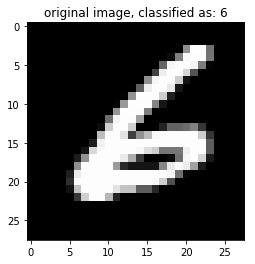

TypeError: Invalid dimensions for image data

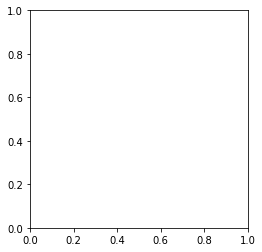

In [13]:
# obtain one sample
image, _ = dataset.get_sample(show_image=False)
before = np.argmax(cnn(image.squeeze(-1)).detach()).item()

mode = "PP"
best_delta = CEM.explain(image, mode=mode)

if mode == "PP":
    after = np.argmax(cnn(image.squeeze(-1) - best_delta.view(1,28,28)).detach()).item()
else:
    after = np.argmax(cnn(best_delta.view(1,28,28)).detach()).item()
        
plt.imshow(image.squeeze(), cmap="gray")
plt.title("original image, classified as: {}".format(before))
plt.show()

if mode == "PP":
    plt.imshow(image.squeeze() - best_delta.view(28, 28))
    plt.title("pertinent positive, classified as: {}".format(after))
    plt.show()
else:
    plt.imshow(best_delta.squeeze())
    plt.title("image with pertinent negative, classified as: {}".format(after))
    plt.show()

# Performance of the CEM on the FashionMNIST dataset

In [ ]:
dataset = FashionMNIST(batch_size=64)

In [ ]:
# Train or load autoencoder
cae = CAE(device="cpu")

train_ae(cae, dataset, iterations=10, save_fn="fashion-mnist-cae", device="cpu", load_path="models/saved_models/fashion-mnist-cae.h5")